In [1]:
from preprocessing import *
from word_swap import *
from activations import *
import torch
from transformers import AutoTokenizer,AutoModel,pipeline
from nltk.corpus import brown
import matplotlib.pyplot as plt

/gpfs/fs2/scratch/snormanh_lab/dskrill/TemporalIntegration/preprocessing.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Obtaining and preprocessing a corpus

For simplicity of demonstration, we use the Brown Corpus, conveniently available from NLTK. The Brown Corpus is a collection of English-language text, totaling roughly one million words, compiled from works published in the United States in 1961. The corpus is divided into 15 genres, such as news, editorial, and fiction; for this demonstration, we use the entire corpus. The files are further divided into sentences and tagged with part-of-speech (POS) tags. For more information on the Brown Corpus, see the [NLTK documentation](http://www.nltk.org/book/ch02.html#brown-corpus).

The following code imports the Brown Corpus preprocesses each sentence. The preprocessing:
- Removes punctuation
- Converts all words to lowercase

Additionally, this step removes sentences containing proper nouns or non-alphabetical characters.

In [5]:
corpus = Corpus(brown)

  0%|          | 0/57340 [00:00<?, ?it/s]

  0%|          | 0/1004244 [00:00<?, ?it/s]

We can filter the preprocessed sentences to retain only those having particular lengths:

In [6]:
selected_sentences = corpus.get_sentences_of_length(12)

For example, we inspect the first five 12-word sentences:

In [7]:
[" ".join(selected_sentences[i]) for i in range(5)]

['under committee rules it went automatically to a subcommittee for one week',
 'nothing has been done yet to take advantage of the enabling legislation',
 'how can a man with any degree of common decency charge this',
 'he then launched into what the issues should be in the campaign',
 'there is a tangible feeling in the air of revulsion toward politics']

We can also similarly extract and preprocess sequences of natural text (not necessarilly delimited by sentence boundaries):

In [8]:
natural_sequences = corpus.get_natural_sequences_of_length(40)

In [9]:
for i,word in enumerate(natural_sequences[0][:10]):
    print(f"{i} {word}:{corpus.word_lookup[word]}")

0 party:NN
1 leaders:NNS
2 came:VBD
3 out:RP
4 of:IN
5 the:AT
6 final:JJ
7 meeting:NN
8 apparently:RB
9 satisfied:VBN


The Corpus object also has a dictionary that allows one to lookup words having a given POS-tag, e.g., adjectives (`JJ`):

In [10]:
corpus.pos_dict["JJ"][:10]

['recent',
 'overall',
 'possible',
 'hardfought',
 'relative',
 'such',
 'widespread',
 'outmoded',
 'inadequate',
 'ambiguous']

Lastly, one can similarly extract noun phrases from the corpus. For convenience, we repurpose the preprocessed sentences obtained above.

In [11]:
noun_phrases = corpus.get_noun_phrases_of_length(8)

In [12]:
[" ".join(noun_phrases[i]) for i in range(5)]

['the entire two and a half mile length',
 'the same three month period toll road bonds',
 'the only or even the most appropriate conceptuality',
 'the intellectual social political and economic attitudes institutions',
 'the true color texture complexity range intensity pulse']

# Word swap procedure

Now that the corpus has been preprocessed, we can create sequences and perform the word swap procedure. The nature of the input sequences and the method of selecting the swapped word vary with the analysis at hand, but the word swap procedure remains the same. Specifically:

- To assess overall integration, we use sequences of natural text(e.g., of 40 words in length), and make swaps using randomly selected words having the same POS-tag.
- To assess structure yoking, we create sequences of five structures of prespecified length (e.g., 12-word sentences), and make swaps from a pool of words selected based on the difference in the embeddings betwen the original and candidate words.
- We also consider making swaps using probable (or improbable) words, as determined (independently) by BERT.

We found that sentence-final words yielded slightly more tokens on average than words in other positions. To account for this in the structure yoking analysis, we tokenize all candidate sentences and used only those that are comprised entirely of single-token words.

One can instantiate a tokenizer and model as follows:


In [13]:
model_type = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(
    model_type, add_special_token=False,add_prefix_space=True)
model = AutoModel.from_pretrained(model_type)

The Corpus also needs to be reinitialized with the new tokenizer:

In [14]:
corpus = Corpus(brown,single_token_words=True,tokenizer=tokenizer)

  0%|          | 0/57340 [00:00<?, ?it/s]

  0%|          | 0/1004244 [00:00<?, ?it/s]

GPT-2 does not have any structure-delimiting tokens. Other models (e.g., BERT) do have such tokens, which need to be excluded.

In [15]:
yoking_sequences = create_yoking_sequences(
    sentences = corpus.get_sentences_of_length(12),
    tokenizer = tokenizer,
    excluded_token_ids = []
)

In [16]:
" ".join(yoking_sequences[0][:24])

'issuing bonds for plant construction has brought new industries to certain regions the atmosphere is that of an attractive private beach club at home'

In [17]:
class WordSwap:
    def __init__(self,excluded_token_ids=[]):
        self.original_sequences = []
        self.swapped = []
        self.excluded_token_ids = excluded_token_ids 

        self.ok = True

    def __call__(self,sequences):
        pass

class RandomWordSwap(WordSwap):
    def __init__(self,excluded_token_ids=[]):
        super().__init__(excluded_token_ids=excluded_token_ids)

    def __repr__(self):
        return "Word swaps using random choice from word list"

    def __call__(self,sequences):
        n_sequences = len(sequences)

        for sequence_num,s in tqdm(enumerate(sequences)):
            other = sequences[np.random.choice(range(n_sequences),1)[0]]
            swapped_sequences = []
            for i,word in enumerate(s):
                temp = s.copy()
                to_swap = random.choice(word_list)
                while to_swap == word:
                    to_swap = random.choice(word_list)
                temp[i] = to_swap
                swapped_sequences.append(temp)

            self.swapped.append(swapped_sequences)
            self.original_sequences.append(s)

class RandomPosWordSwap(WordSwap):
    def __init__(self,word_lookup,pos_dict,tokenizer,excluded_token_ids = []):
        super().__init__(excluded_token_ids=excluded_token_ids)
        self.word_lookup = word_lookup
        self.pos_dict = pos_dict
        self.tokenizer = tokenizer
        self.word_list = []
        for w in list(word_lookup.keys()):
            tokens = [t for t in tokenizer.encode(w) if t not in excluded_token_ids]
            if len(tokens) == 1:
                self.word_list.append(w)
    
    def __repr__(self):
        return "Word swaps using random choice from same POS"

    def __call__(self,sequences):
        for sequence_num,s in tqdm(enumerate(sequences)):
            swapped_sequences = []
            for i,word in enumerate(s):
                temp = s.copy()
                current_pos = self.word_lookup[word]
                if current_pos not in self.pos_dict:
                    print("Warning: ",current_pos," not in pos_dict")
                    print(word)
                    to_swap = random.choice(self.word_list)
                else:
                    to_swap = random.choice(self.pos_dict[current_pos])
                try_count = 0
                token = self.tokenizer.encode(to_swap)
                token = [t for t in token if t not in self.excluded_token_ids]
                while (to_swap == word) or len(token)>1:
                    if (try_count < 10) and (current_pos in self.pos_dict):
                        to_swap = random.choice(self.pos_dict[current_pos]) # some rare pos tags may not have many words
                        token = self.tokenizer.encode(to_swap)
                        token = [t for t in token if t not in self.excluded_token_ids]
                        try_count += 1
                        # print(try_count,current_pos)
                        if try_count == 10:
                            print(f"Warning: {current_pos} has few words (current word: {word})")
                            break
                    else:
                        to_swap = random.choice(self.word_list) # just pick randomly in that case
                        break
                temp[i] = to_swap
                swapped_sequences.append(temp)
            self.swapped.append(swapped_sequences)
            self.original_sequences.append(s)



pos_swapper = RandomPosWordSwap(corpus.word_lookup,corpus.pos_dict,tokenizer)
pos_swapper(yoking_sequences[:250])



0it [00:00, ?it/s]

After calling them on an appropriate list of sequences, the word swap objects have attributes `swapped` and `original_sequences` that contain the swapped and original sequences, respectively. `swapped` is a list of lists: `swapped[i][j]` is the ith sequence with the jth word swapped. Indices are zero-indexed.

In [18]:
i = 0
j = 5
print("Original: " + " ".join(pos_swapper.original_sequences[i][:10]) + " ..."),
print(f"Swapped at {j}: " + " ".join(pos_swapper.swapped[i][j][:10]) + " ...") 
print(f"Swapped at {j+1}: " + " ".join(pos_swapper.swapped[i][j+1][:10]) + " ...") 

Original: issuing bonds for plant construction has brought new industries to ...
Swapped at 5: issuing bonds for plant construction to brought new industries to ...
Swapped at 6: issuing bonds for plant construction has faced new industries to ...


Let's also see how the other swap procedures work:

In [51]:
word_list = list(corpus.word_lookup.keys())
word_list,tokens = filter_word_list(word_list, tokenizer,[])
candidate_embeddings = create_candidate_embeddings(tokens,model.base_model.wte.forward)
sampling_params = {'mean':.125,'half_width':.003,'spacing':.001,'size':100}
distribution_swapper = DistributionWordSwap(word_list,
                                            candidate_embeddings,
                                            model.base_model.wte.forward,
                                            sampling_params,
                                            tokenizer,
                                            excluded_token_ids = [])


  0%|          | 0/14999 [00:00<?, ?it/s]

Candidate embeddings created of shape:  torch.Size([14999, 768])


In [52]:
distribution_swapper(yoking_sequences[:10])

0it [00:00, ?it/s]

Using random word sub for:  stride


In [53]:
print("Original: " + " ".join(distribution_swapper.original_sequences[i][:10])),
print(f"Swapped at {j}: " + " ".join(distribution_swapper.swapped[i][j][:10])) 
print(f"Swapped at {j+1}: " + " ".join(distribution_swapper.swapped[i][j+1][:10])) 

Original: issuing bonds for plant construction has brought new industries to
Swapped at 5: issuing bonds for plant construction roundup brought new industries to
Swapped at 6: issuing bonds for plant construction has bedrooms new industries to


In [22]:
unmasker = pipeline('fill-mask',model = 'bert-large-uncased-whole-word-masking',top_k=1000,device='cpu')
probable_swapper = ProbableWordSwap(unmasker,idx_low = 0,idx_high = 5,sentence_len = 12,excluded_token_ids = [])
probable_swapper(yoking_sequences[:10])


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0it [00:00, ?it/s]

In [23]:
print("Original: " + " ".join(probable_swapper.original_sequences[i][:10])),
print(f"Swapped at {j}: " + " ".join(probable_swapper.swapped[i][j][:10])) 
print(f"Swapped at {j+1}: " + " ".join(probable_swapper.swapped[i][j+1][:10])) 

Original: issuing bonds for plant construction has brought new industries to
Swapped at 5: issuing bonds for plant construction which brought new industries to
Swapped at 6: issuing bonds for plant construction has introduced new industries to


# Obtaining activations

Having obtained the swapped sequences, we can now obtain activations for each sequence. The activations are obtained by passing the sequences through an LLM and extracting the activations. Typically, the 0th layer of the LLM is a non-contextual embedding layer; subsequent layers are contextual. 

Unless one has restricted the analysis to only single-token words, some words will likely be tokenized into multiple tokens. In this case, we take the mean of the activations for the tokens comprising the word. We do this by first creating a Pandas DataFrame from the text, which makes it convenient to track which tokens correspond to each word. The funcion that extacts the activations takes this DataFrame as input.

In [24]:
text_to_df(probable_swapper.original_sequences[0],tokenizer=tokenizer)

,word,tokens,n_tokens_in_word,decoded
0,issuing,[19089],1,[Ġissuing]
1,bonds,[13100],1,[Ġbonds]
2,for,[329],1,[Ġfor]
3,plant,[4618],1,[Ġplant]
4,construction,[5103],1,[Ġconstruction]
5,has,[468],1,[Ġhas]
6,brought,[3181],1,[Ġbrought]
7,new,[649],1,[Ġnew]
8,industries,[11798],1,[Ġindustries]
9,to,[284],1,[Ġto]


In [37]:
swapped_seqs = pos_swapper.swapped
original_seqs = pos_swapper.original_sequences
differences = calculate_differences(swapped_seqs,original_seqs,tokenizer,model,device='cuda')

0it [00:00, ?it/s]

Finished calculating difference tensor for  250  sequences


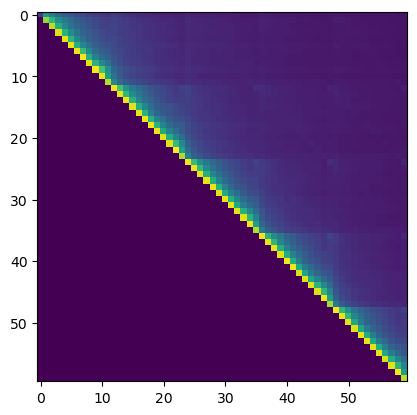

In [40]:
import matplotlib.pyplot as plt
plt.imshow(differences.mean(-1)[11])

# Reproducing analyses

## Overall integration

In [61]:
model_type = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(
    model_type, add_special_token=False,add_prefix_space=True)
model = AutoModel.from_pretrained(model_type)

overall_integration_corpus = Corpus(brown,single_token_words=False,tokenizer=tokenizer)
overall_integration_swapper = RandomPosWordSwap(overall_integration_corpus.word_lookup,
                                                overall_integration_corpus.pos_dict,
                                                tokenizer)
natural_sequences_40 = overall_integration_corpus.get_natural_sequences_of_length(40)
len(natural_sequences_40)

  0%|          | 0/57340 [00:00<?, ?it/s]

  0%|          | 0/1004244 [00:00<?, ?it/s]

  0%|          | 0/14999 [00:00<?, ?it/s]

Candidate embeddings created of shape:  torch.Size([14999, 768])


In [55]:
overall_integration_swapper(natural_sequences_40)
differences = calculate_differences(overall_integration_swapper.swapped,
                                    overall_integration_swapper.original_sequences,
                                    tokenizer,model,device='cuda')

0it [00:00, ?it/s]

Using random word sub for:  cathodoluminescent


0it [00:00, ?it/s]

Finished calculating difference tensor for  114  sequences


In [58]:
from analysis import *
print("differences shape: ",differences.shape)
D = np.transpose(differences.numpy(), (3, 1, 2, 0))
print("D shape: ",D.shape)
n_features, n_stim_time, n_model_time, n_layers = D.shape
all_fits, all_D_delta = fit_curves(D)

differences shape:  torch.Size([13, 40, 40, 768])
D shape:  (768, 40, 40, 13)


  0%|          | 0/768 [00:00<?, ?it/s]

In [59]:
stacked_fits = [np.stack(fit) for fit in all_fits]
stacked_fits = np.stack(stacked_fits)
stacked_fits.shape

(768, 13, 3)

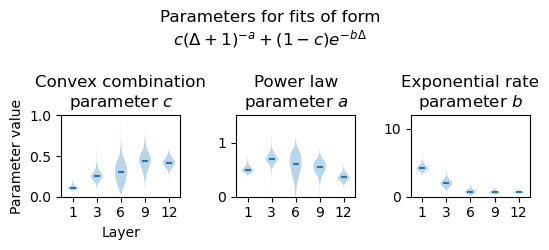

In [60]:
fig,axes = plt.subplots(figsize=(5.5,2.5),nrows=1,ncols=3,sharex=True,sharey=False)

for i,(plot_idx,to_plot) in enumerate(zip([2,0,1],['c','a','b'])):    
    layers = [1,3,6,9,12]
    ranges = [[0,1.5],[0,12],[0,1]]
    axes[i].violinplot(stacked_fits[:,layers,plot_idx],showextrema=False,showmedians=True)
    if i ==0:
        axes[i].set_xticks(range(1,6),layers)
        axes[i].set_xlabel('Layer')
        axes[i].set_ylabel('Parameter value')
    axes[i].set_ylim(ranges[plot_idx])
    if to_plot == 'a':
        axes[i].set_title(r'Power law' '\n' r'parameter $a$')
    elif to_plot == 'b':
        axes[i].set_title(r'Exponential rate' '\n' r'parameter $b$')
    elif to_plot == 'c':
        axes[i].set_title(r'Convex combination' '\n' r'parameter $c$')
fig.suptitle('Parameters for fits of form' '\n' r'$c (\Delta + 1)^{-a} + (1 - c)  e^{-b  \Delta}$')
fig.tight_layout()

## Structure yoking

In [65]:
model_type = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(
    model_type, add_special_token=False,add_prefix_space=True)
model = AutoModel.from_pretrained(model_type)

structure_yoking_corpus = Corpus(brown,single_token_words=True,tokenizer=tokenizer)
word_list = list(structure_yoking_corpus.word_lookup.keys())
word_list,tokens = filter_word_list(word_list, tokenizer,[])
candidate_embeddings = create_candidate_embeddings(tokens,model.base_model.wte.forward)
sampling_params = {'mean':.125,'half_width':.003,'spacing':.001,'size':100}
structure_yoking_swapper = DistributionWordSwap(word_list,
                                            candidate_embeddings,
                                            model.base_model.wte.forward,
                                            sampling_params,
                                            tokenizer,
                                            excluded_token_ids = [])

yoking_sequences = create_yoking_sequences(
    sentences = corpus.get_sentences_of_length(12),
    tokenizer = tokenizer,
    excluded_token_ids = []
)

len(yoking_sequences)

  0%|          | 0/57340 [00:00<?, ?it/s]

  0%|          | 0/1004244 [00:00<?, ?it/s]

  0%|          | 0/14999 [00:00<?, ?it/s]

Candidate embeddings created of shape:  torch.Size([14999, 768])


250

In [66]:
structure_yoking_swapper(yoking_sequences)
differences_yoking = calculate_differences(structure_yoking_swapper.swapped,
                                    structure_yoking_swapper.original_sequences,
                                    tokenizer,model,device='cuda')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Finished calculating difference tensor for  250  sequences


In [63]:
D_yoking = np.moveaxis(differences_yoking.numpy(), 0,-1)
n_swap_time, n_model_time,n_units, n_layers = D_yoking.shape
boundary_times = np.arange(0,D_yoking.shape[0],12)

(40, 40, 768, 13)

In [ ]:
n_offdiag = 12 - 1 # number of off-diagonal entries to consider
fdiff = np.full((n_swap_time, n_layers,n_units), np.nan)
for i in range(n_layers):
    for u in range(n_units):
        mdiag = np.median(np.diag(D[:,:,u,i]))
        for j in range(n_swap_time-n_offdiag-1):
            d = D[j+1,j+1:(j+1+n_offdiag),u,i]-D[j,j:(j+n_offdiag),u,i]
            fdiff[j+1,i,u] = np.mean(d)/mdiag


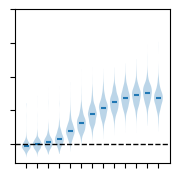

In [72]:
def yoking_plots(D,sentence_len):

    D = np.moveaxis(D, 0,-1)
    n_swap_time, n_model_time,n_units, n_layers = D.shape
    boundary_times = np.arange(0,D.shape[0],sentence_len)

    # compute first order differences
    n_offdiag = sentence_len - 1 # number of off-diagonal entries to consider
    fdiff = np.full((n_swap_time, n_layers,n_units), np.nan)
    for i in range(n_layers):
        for u in range(n_units):
            mdiag = np.median(np.diag(D[:,:,u,i]))

            for j in range(n_swap_time-n_offdiag-1):
                d = D[j+1,j+1:(j+1+n_offdiag),u,i]-D[j,j:(j+n_offdiag),u,i]
                fdiff[j+1,i,u] = np.mean(d)/mdiag

    if model == "gpt2":
        yL = np.array([-1.05,1.05])*np.nanmax(fdiff[sentence_len:-sentence_len])
        layers = [12]
        for i, (layer) in enumerate(layers):
            ax = plt.figure(figsize = (2,2)).gca()
            ax.set_ylim(yL)
            ax.plot(np.arange(sentence_len,n_swap_time), fdiff[sentence_len:,i,:],color='grey',alpha=.5,label = "Indiv. units")
            for l in range(len(boundary_times)):
                ax.plot(boundary_times[l]*np.array([1,1]), yL, 'k--', label = "Sentence boundary")
            ax.plot(np.arange(sentence_len,n_swap_time), fdiff.mean(-1)[sentence_len:,i], linewidth=1.5,color='red',label = "Mean")
        

            ax.set_xticks(boundary_times,labels = '')
            ax.set_yticks([-.1,.1],'')
            ax.set_xlim([11, 47])
            plt.savefig(os.path.join(path,f"first_order_differences_vector_sentences_{sentence_len}_layer_{layer}.png"))
            plt.close()

    ax = plt.figure(figsize = (2,2)).gca()
    n_sentences = 5
    fdiff_circ = fdiff[sentence_len:].reshape(sentence_len, n_sentences-1, n_layers,n_units, order='F')
    yoking_index = np.nanmean(fdiff_circ[0,:,:,:], axis=0)
    ax.violinplot(positions = np.arange(0,n_layers), dataset=yoking_index.T, showmeans=False, showextrema=False, showmedians=True,widths=0.8)
    ax.axhline(0, color='k', linestyle='--', linewidth=1)
    ax.tick_params(labelright= False,labeltop= False,labelleft= False, labelbottom= False)
    ax.set_xticks(range(n_layers))
    ax.set_yticks([0,.05,.1,.15,.2],'')

yoking_plots(differences_yoking.numpy(), 12)
